In [72]:
library(kernlab)
library(DataExplorer)
library(finalfit)
library(dplyr)
library(class)
library(ggplot2)
library(gmodels)


Dołączanie pakietu: 'ggplot2'


Następujący obiekt został zakryty z 'package:kernlab':

    alpha




# Load dataset

In [4]:
data(spam)

## Descriptive analysis and data visualization

In [5]:
introduce(spam)

rows,columns,discrete_columns,continuous_columns,all_missing_columns,total_missing_values,complete_rows,total_observations,memory_usage
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
4601,58,1,57,0,0,4601,266858,2128920


In [9]:
any(is.na(spam))

[1] FALSE

No missing values

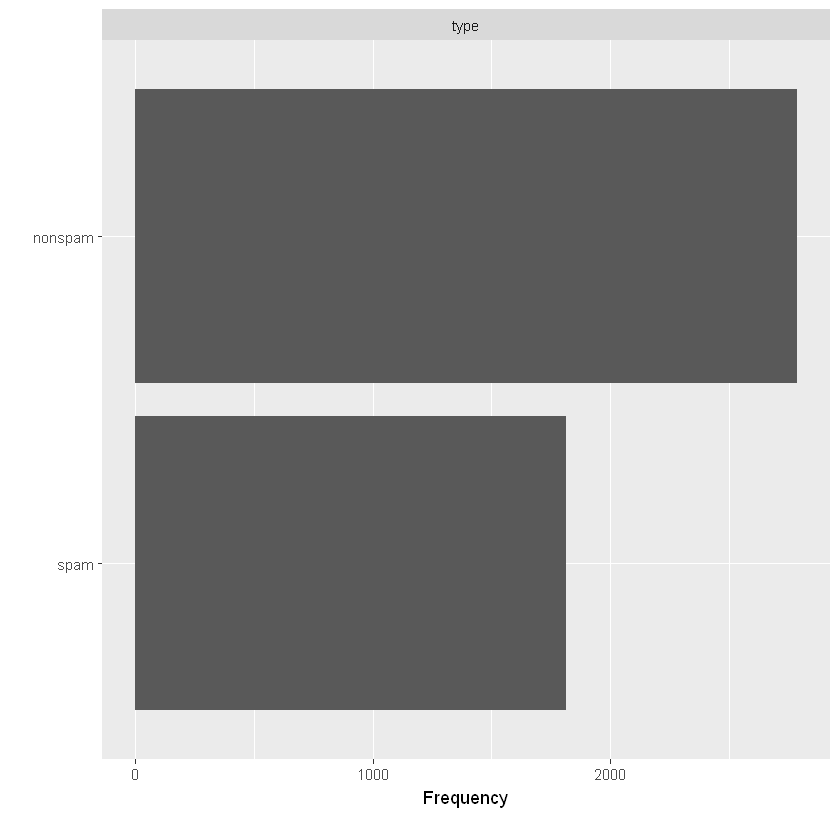

In [6]:
plot_bar(spam)

There's no huge class imbalance

### Some plots to display data information

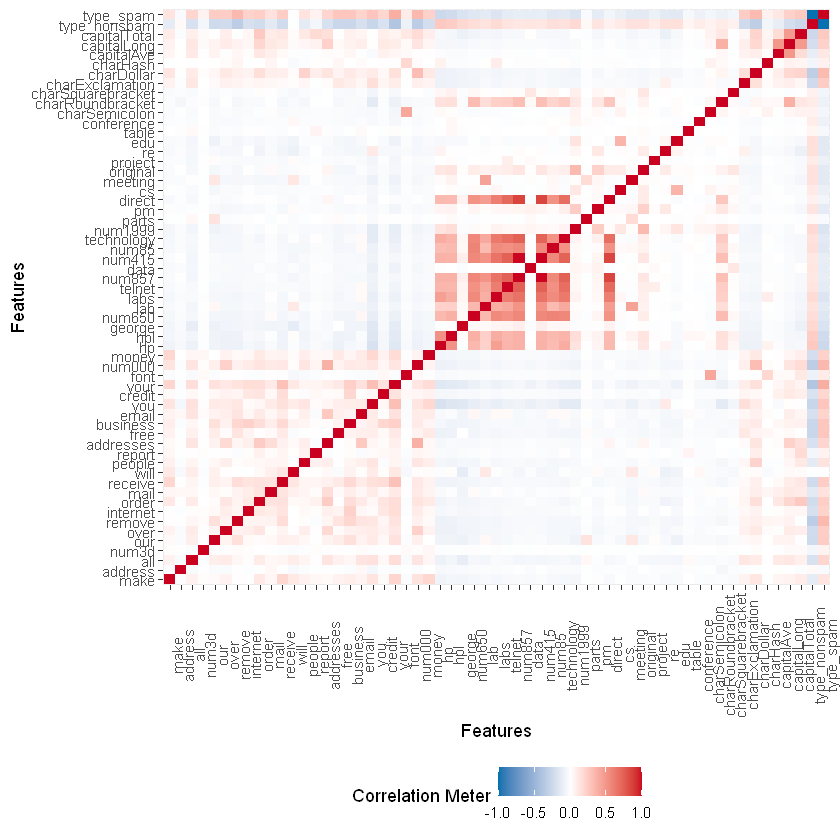

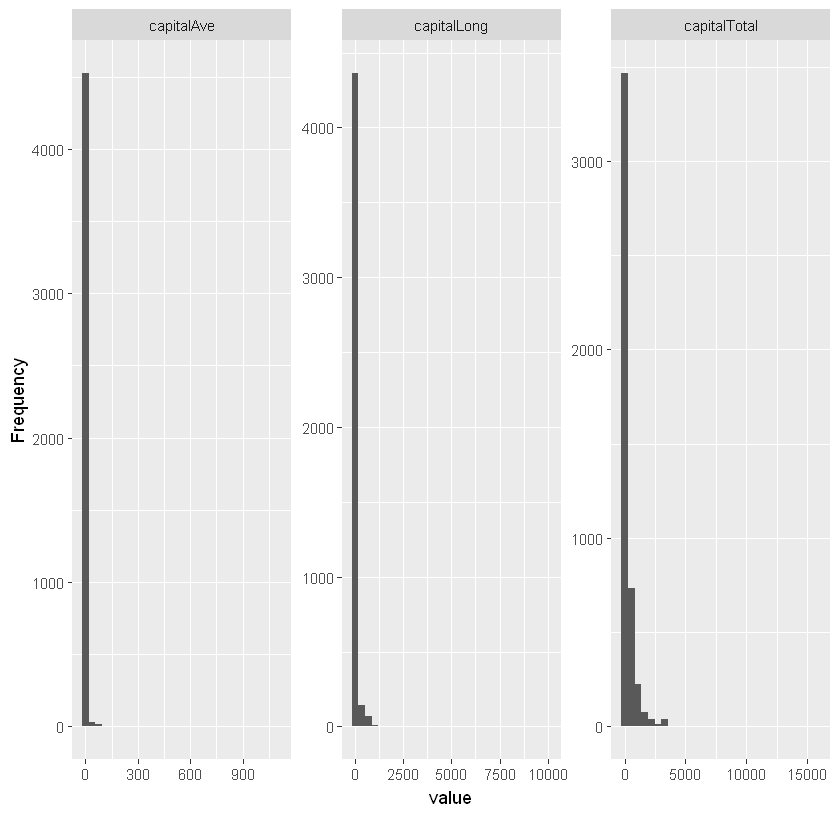

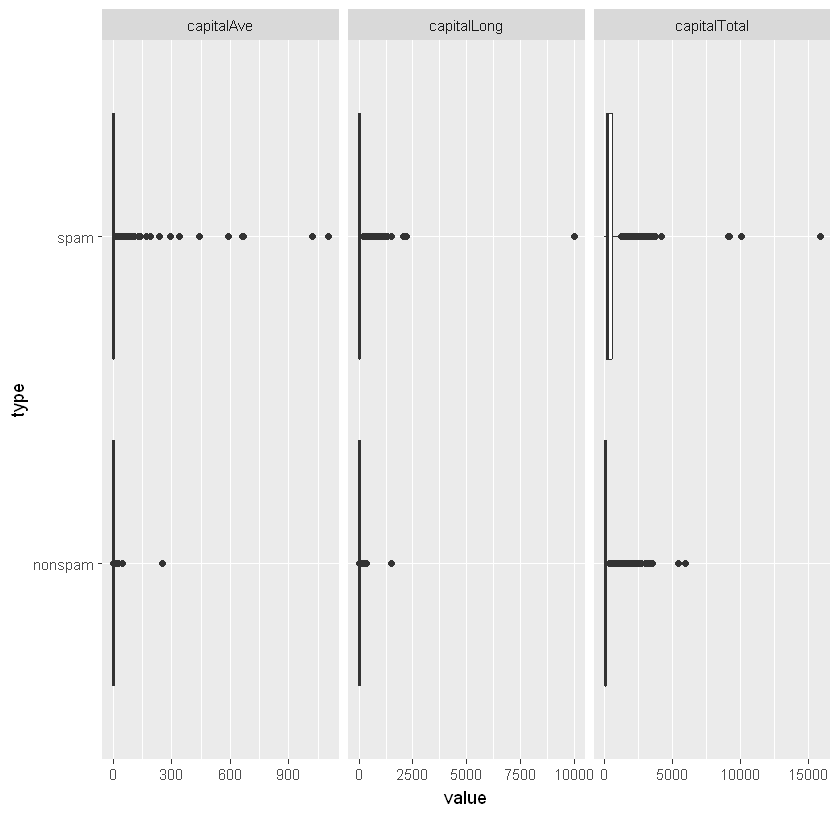

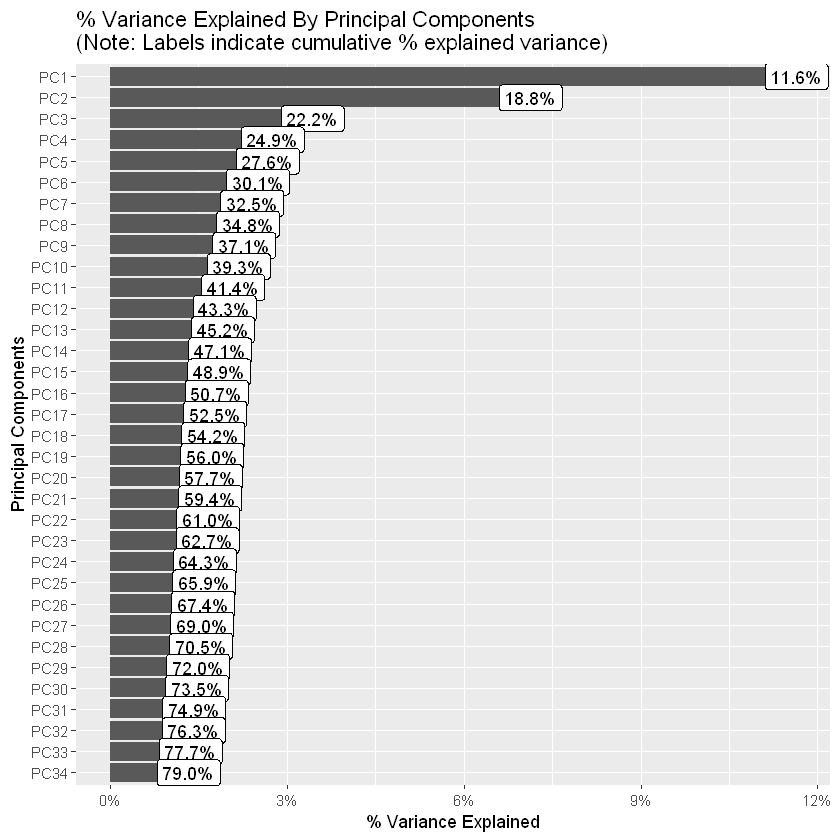

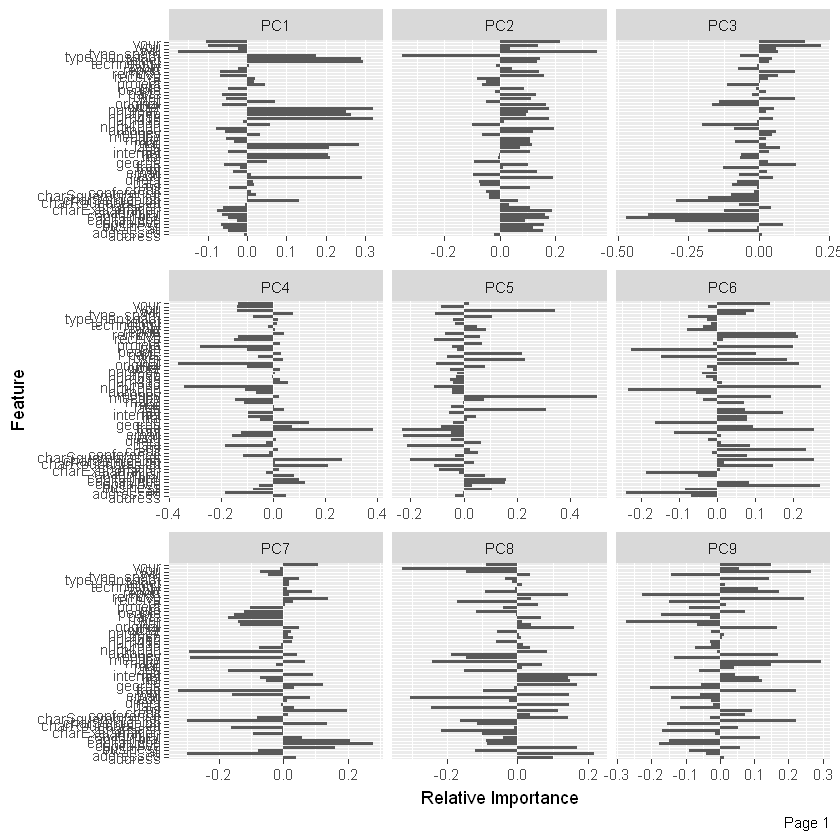

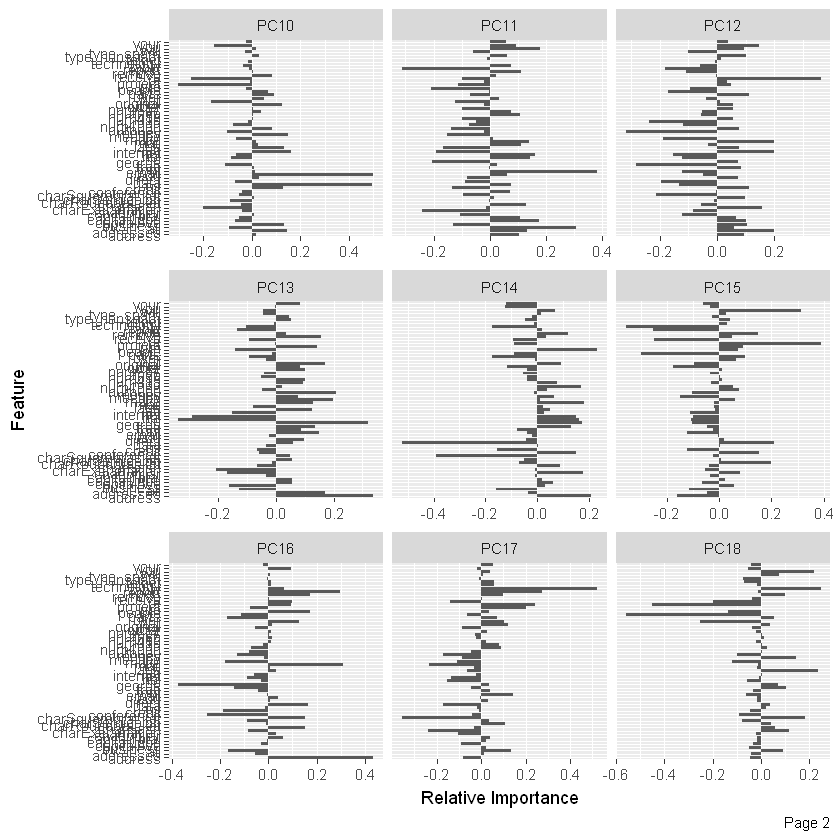

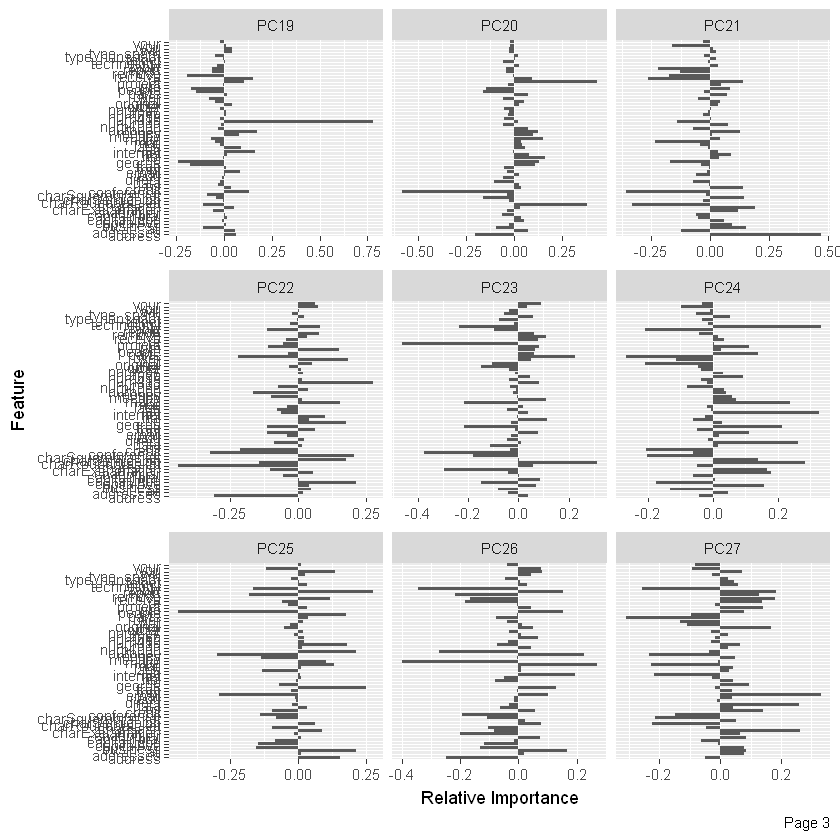

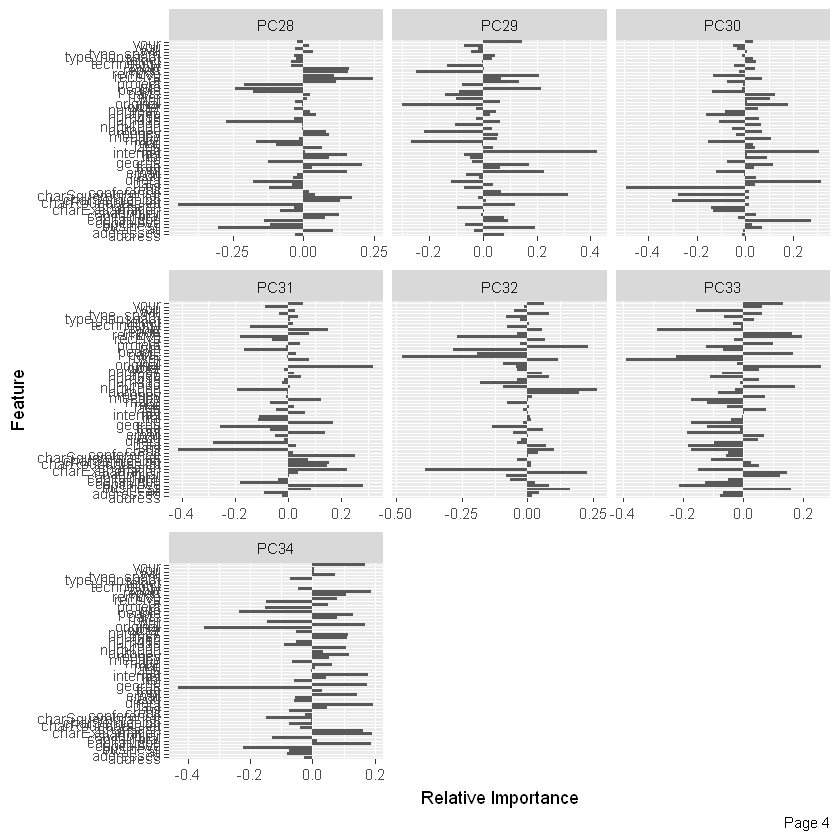

In [7]:
plot_correlation(spam)
plot_histogram(spam[55:57])
plot_boxplot(spam[55:58], by = "type")
plot_prcomp(spam, maxcat = 5L)

## Classification using k-NN and Decision tree algorithms

### k-NN

In [24]:
summary(spam$type)

nonspam    spam 
   2788    1813

In [25]:
#Percentage of Benign and Malignant
round(prop.table(table(spam$type)) * 100, 2)


nonspam    spam 
   60.6    39.4 

In [26]:
#function to normalize the data
normalize_data <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

In [51]:
normalized_spam <- as.data.frame(lapply(spam[1:57], normalize_data))
normalized_spam$type <- spam$type

# Splitting data to training and testing sets

In [64]:
set.seed(1420)

In [65]:
samples <- sample(nrow(spam), 0.8 * nrow(spam))
training_data <- spam[samples, ]
test_data <- spam[-samples, ]
training_data_normalized <- normalized_spam[samples, ]
test_data_normalized <- normalized_spam[-samples, ]

In [66]:
knn_prediction <- knn(train = training_data[, 1:57],
                      test = test_data[, 1:57],
                      cl = training_data[, 58],
                      k = 1)

In [67]:
knn_prediction_normalized <- knn(train = training_data_normalized[, 1:57],
                                 test = test_data_normalized[, 1:57],
                                 cl = training_data_normalized[, 58],
                                 k = 1)

### Cross tables for normalized and not normalized data

In [68]:
CrossTable(x = test_data[, 58], 
           y = knn_prediction,
           prop.chisq = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  921 

 
                | knn_prediction 
test_data[, 58] |   nonspam |      spam | Row Total | 
----------------|-----------|-----------|-----------|
        nonspam |       480 |        73 |       553 | 
                |     0.868 |     0.132 |     0.600 | 
                |     0.842 |     0.208 |           | 
                |     0.521 |     0.079 |           | 
----------------|-----------|-----------|-----------|
           spam |        90 |       278 |       368 | 
                |     0.245 |     0.755 |     0.400 | 
                |     0.158 |     0.792 |           | 
                |     0.098 |     0.302 |           | 
----------------|-----------|-----------|-----------|
   Column Total |       570 |       351 |       921 | 
                |     0.6

In [69]:
CrossTable(x = test_data_normalized[, 58], 
           y = knn_prediction_normalized,
           prop.chisq = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  921 

 
                           | knn_prediction_normalized 
test_data_normalized[, 58] |   nonspam |      spam | Row Total | 
---------------------------|-----------|-----------|-----------|
                   nonspam |       503 |        50 |       553 | 
                           |     0.910 |     0.090 |     0.600 | 
                           |     0.901 |     0.138 |           | 
                           |     0.546 |     0.054 |           | 
---------------------------|-----------|-----------|-----------|
                      spam |        55 |       313 |       368 | 
                           |     0.149 |     0.851 |     0.400 | 
                           |     0.099 |     0.862 |           | 
                           |     0.060 |     0.340 |     

We see that normalization improves $kNN$ algorithm accuracy so let's try to further improve the precision by checking different values of $k$ for the $kNN$ algorithm.

In [74]:
find_optimal_neighbors <- function(training_data, test_data) {
  errors <- numeric(14)
  for (k in 1:15) {
    prediction <- knn(train = training_data[, 1:57],
                      test = test_data[, 1:57],
                      cl = training_data[, 58],
                      k = k)
    errors[k] <- 1 - mean(prediction == test_data$type)
  }
  return(errors)
}

In [75]:
errors <- find_optimal_neighbors(training_data_normalized, test_data_normalized)

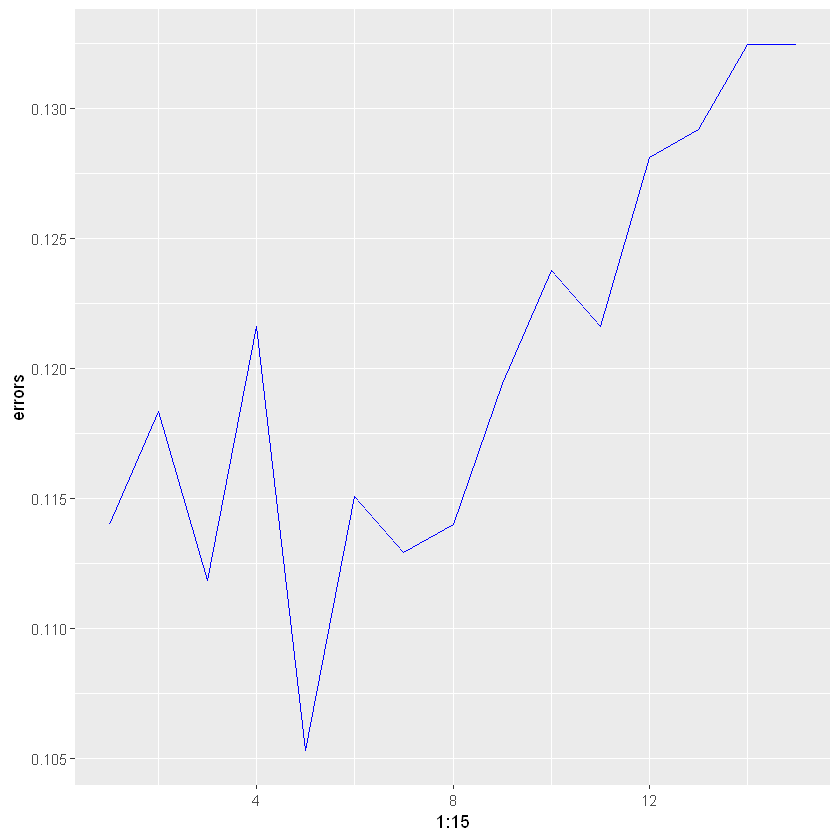

In [76]:
ggplot(data = data.frame(errors), aes(x = 1:15, y = errors)) +
  geom_line(color = "Blue")

We can see that in this case we may experience overfitting for too many nearest neighbors. Let's try to use $k=5$ as it seems to be the best value and prepare a cross table for it.

In [77]:
knn_prediction_normalized_5 <- knn(train = training_data_normalized[, 1:57],
                                   test = test_data_normalized[, 1:57],
                                   cl = training_data_normalized[, 58],
                                   k = 5)

In [78]:
CrossTable(x = test_data_normalized[, 58], 
           y = knn_prediction_normalized_5,
           prop.chisq = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  921 

 
                           | knn_prediction_normalized_5 
test_data_normalized[, 58] |   nonspam |      spam | Row Total | 
---------------------------|-----------|-----------|-----------|
                   nonspam |       510 |        43 |       553 | 
                           |     0.922 |     0.078 |     0.600 | 
                           |     0.903 |     0.121 |           | 
                           |     0.554 |     0.047 |           | 
---------------------------|-----------|-----------|-----------|
                      spam |        55 |       313 |       368 | 
                           |     0.149 |     0.851 |     0.400 | 
                           |     0.097 |     0.879 |           | 
                           |     0.060 |     0.340 |   

The prediction is slightly better but changing $k$ didn't help much.